In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt   
import seaborn as sns

In [39]:
# Load the data
df = pd.read_csv('../data/benin-malanville.csv')

In [40]:
# Basic stats (row count,std,mean, min, max,and the percentiles) for numeric columns.
#df.describe()
# Check if GHI values are in different units (e.g., W vs. kW)
print(df['GHI'].describe())  # Compare between machines

count    525600.000000
mean        240.559452
std         331.131327
min         -12.900000
25%          -2.000000
50%           1.800000
75%         483.400000
max        1413.000000
Name: GHI, dtype: float64


In [41]:
#structural summary  for df.info() 
df.info()
#Additional summary of COLUMN WITH >5% missing values
missing_values = df.isnull().sum()
missing_percent = (missing_values/len(df))*100
missing_summary = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percent})
missing_summary = missing_summary[missing_summary['Percentage'] > 5]
#print the summary
print("Missing values",missing_summary)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525600 entries, 0 to 525599
Data columns (total 19 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Timestamp      525600 non-null  object 
 1   GHI            525600 non-null  float64
 2   DNI            525600 non-null  float64
 3   DHI            525600 non-null  float64
 4   ModA           525600 non-null  float64
 5   ModB           525600 non-null  float64
 6   Tamb           525600 non-null  float64
 7   RH             525600 non-null  float64
 8   WS             525600 non-null  float64
 9   WSgust         525600 non-null  float64
 10  WSstdev        525600 non-null  float64
 11  WD             525600 non-null  float64
 12  WDstdev        525600 non-null  float64
 13  BP             525600 non-null  int64  
 14  Cleaning       525600 non-null  int64  
 15  Precipitation  525600 non-null  float64
 16  TModA          525600 non-null  float64
 17  TModB          525600 non-nul

In [42]:
#FROM THE ABOVE WE CAN SEE THAT COMMENTS IS EMPTY FOR ALL THE ROWS(100% NULL) 
#AND THE COLUMN IS NOT NEEDED FOR OUR ANALYSIS THEREFORE WE DROP IT
df.drop(columns=['Comments'], inplace=True)
print("Shape after dropping:", df.shape)  # Should show (525600, 18) now

Shape after dropping: (525600, 18)


In [43]:
#check for duplicates
df.duplicated().sum() 

np.int64(0)

In [44]:
# Convert timestamp 
df['Timestamp'] = pd.to_datetime(df['Timestamp'])


# Check if timestamp is properly converted
print(df['Timestamp'].dtype)  


datetime64[ns]


In [45]:
#from df.discribe() we can see that the columns DHI, DNI, GHI, HAVE NEGATIVE VALUES WHICH IS NOT POSSIBLE
#THEREFORE WE CAN DROP THE ROWS WITH NEGATIVE VALUES
# Create a mask for negative values
mask = (df[['DHI', 'DNI', 'GHI']] < 0).any(axis=1)
# Drop rows with negative values
df[['GHI', 'DNI', 'DHI']] = df[['GHI', 'DNI', 'DHI']].clip(lower=0)


In [ ]:
#find outliers using Z score >3
from scipy.stats import zscore

# 1) Pick your columns
cols = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']

# 2) Compute Z-scores
z = df[cols].apply(zscore)

# 3) Flag outliers (|Z| > 3)
outliers = (z.abs() > 3)


# 4) Count how many outliers per column
outlier_counts = outliers.sum()
print("Outlier counts:\n", outlier_counts)

# 5) (Optional) See which rows have ANY outlier
bad_rows = df[outliers.any(axis=1)]
#print("\nSample rows with at least one outlier:\n", bad_rows.head())

# 6) (Optional) See which rows have DNI outliers
bad_rows_dni = df[outliers['DNI']]
print("\nSample rows with DNI outliers:\n", bad_rows_dni.head())



Outlier counts:
 GHI         90
DNI          2
DHI       3889
ModA        27
ModB        63
WS        3109
WSgust    3500
dtype: int64

Sample rows with DNI outliers:
                  Timestamp    GHI    DNI    DHI    ModA   ModB  Tamb    RH  \
241274 2022-01-23 13:15:00  943.0  952.3  127.9  1016.4  956.0  30.0  11.9   
241275 2022-01-23 13:16:00  942.0  952.3  127.6  1016.4  955.0  30.1  11.8   

         WS  WSgust  WSstdev     WD  WDstdev   BP  Cleaning  Precipitation  \
241274  6.7     8.4      0.9   97.6      7.2  997         0            0.0   
241275  5.2     7.2      1.0  103.8     12.2  997         0            0.0   

        TModA  TModB  
241274   52.5   42.0  
241275   52.1   41.5  

Sample rows with outliers:
                  Timestamp    GHI    DNI    DHI   ModA   ModB  Tamb    RH  \
343318 2022-04-04 09:59:00  591.3  387.1  295.0  572.4  561.2  34.1  41.1   
296437 2022-03-02 20:38:00    0.0    0.0    0.0    0.0    0.0  28.2  26.3   
353837 2022-04-11 17:18:00  314.6

In [27]:
# Investigate extreme DHI values
#print(df[outliers['DHI']][['Timestamp','DHI','GHI','DNI']].describe())

print(df['DHI'].median())

print(df.loc[outliers['DHI'], 'DHI'].median())
outliers_percent = (outliers['DHI'].sum() / len(df)) * 100

# Replace 'DHI' directly with the median of non-outliers
median_non_outliers = df.loc[~outliers['DHI'], 'DHI'].median()
df['DHI'] = np.where(outliers['DHI'], median_non_outliers, df['DHI'])

# Verify
print("New median:", df['DHI'].median())  # Original column is now modified

0.5
0.5
New median: 0.4


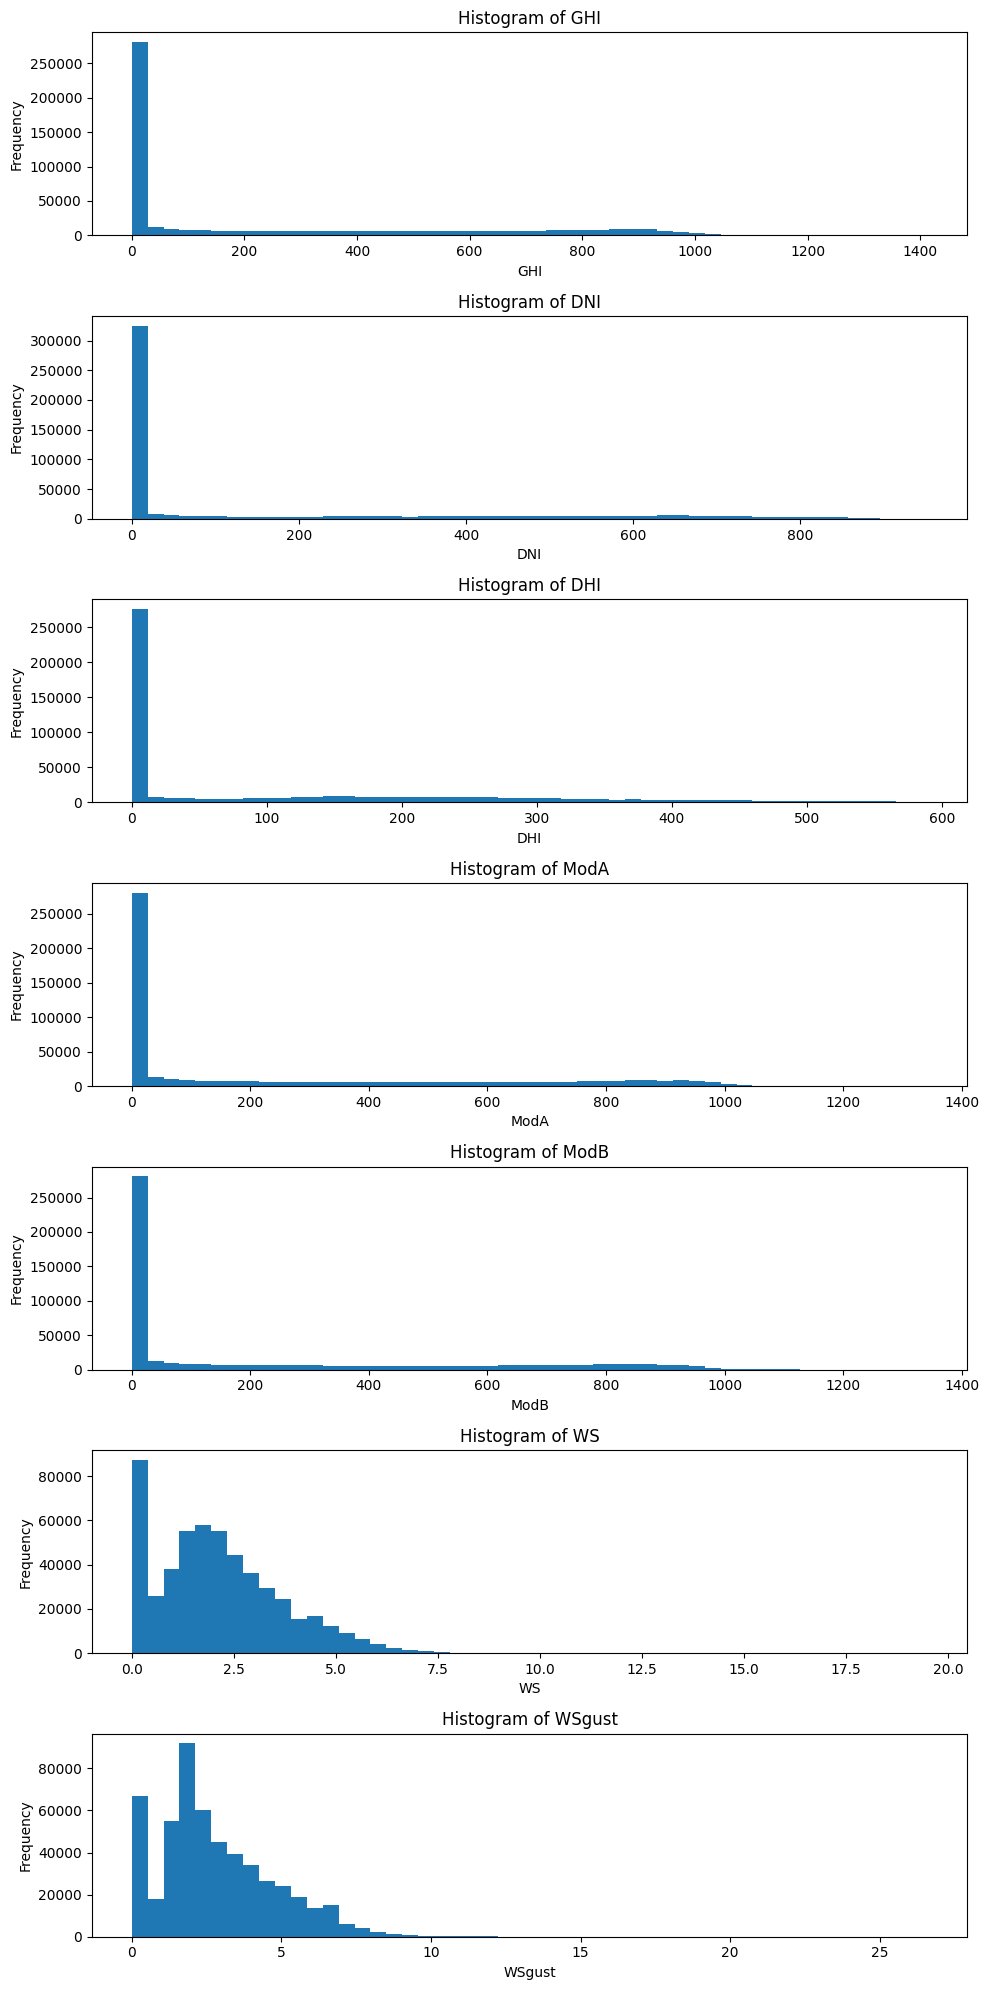

In [ ]:
fig, axes = plt.subplots(nrows=len(cols), figsize=(10, 20))  # Adjust size as needed

# Plot histograms for each column
for ax, col in zip(axes, cols):
    df[col].plot.hist(ax=ax, bins=50, title=f'Histogram of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')

plt.tight_layout()  # Prevent overlapping labels
plt.show()

In [ ]:
# Where DHI > GHI, cap DHI at 90% of GHI (since some diffuse light must exist)

df.loc[df['DHI'] > df['GHI'], 'DHI'] = df['GHI'] * 0.9

In [ ]:
remaining_issues = df[df['DHI'] > df['GHI']]
print(remaining_issues[['GHI','DNI','DHI']].describe())

               GHI          DNI          DHI
count  5229.000000  5229.000000  5229.000000
mean     35.470243     0.513272    36.354657
std      60.829146     3.844394    61.799364
min       0.000000     0.000000     0.100000
25%       1.900000     0.000000     2.200000
50%       8.700000     0.000000     9.100000
75%      40.100000     0.000000    40.800000
max     524.000000   147.200000   524.600000


In [29]:
df['Date'] = df['Timestamp'].dt.date

#sns.barplot(x = "GHI",y= "Timestamp".dt.day hue = 

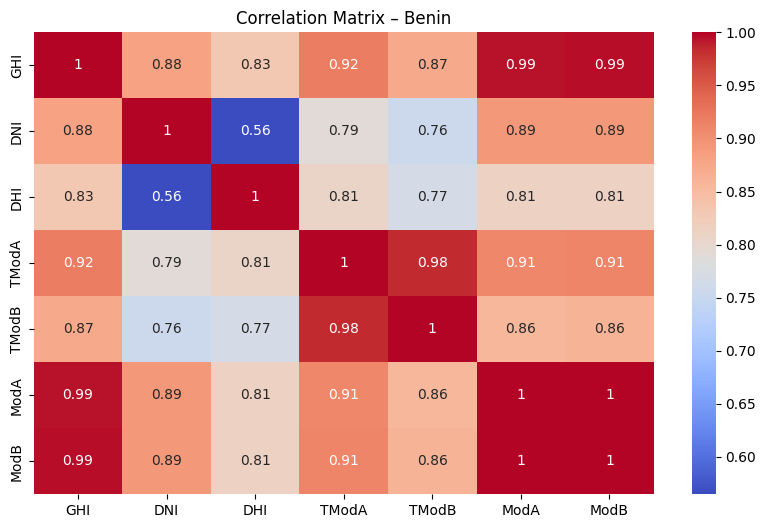

In [28]:


plt.figure(figsize=(10, 6))
sns.heatmap(df[['GHI', 'DNI', 'DHI', 'TModA', 'TModB', 'ModA', 'ModB']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix – Benin")
plt.show()



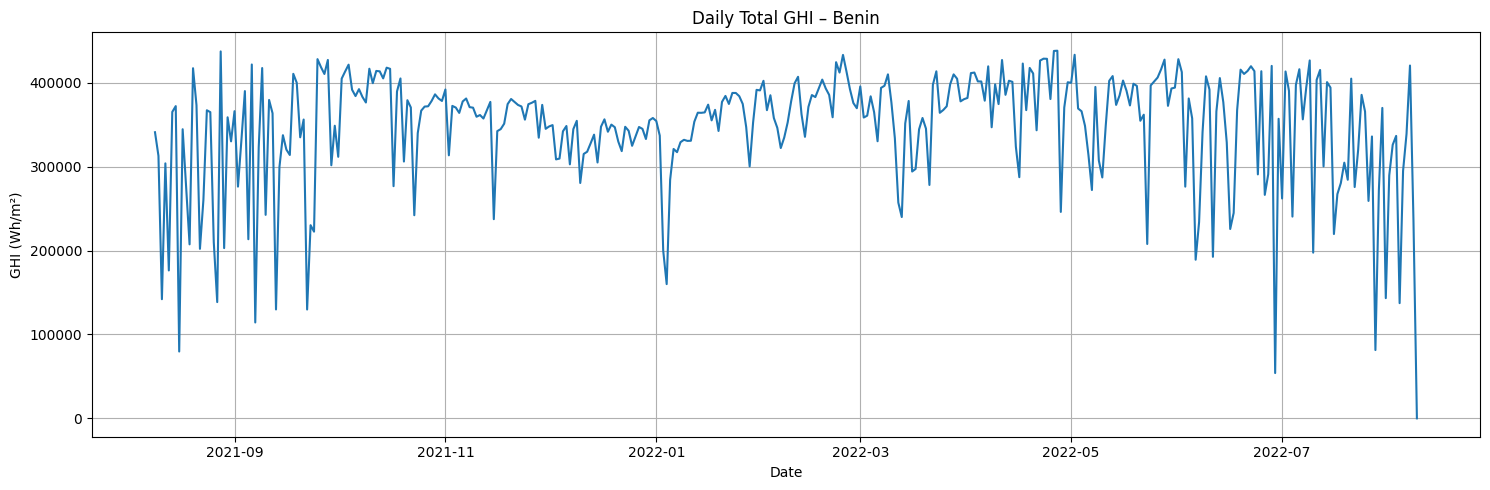

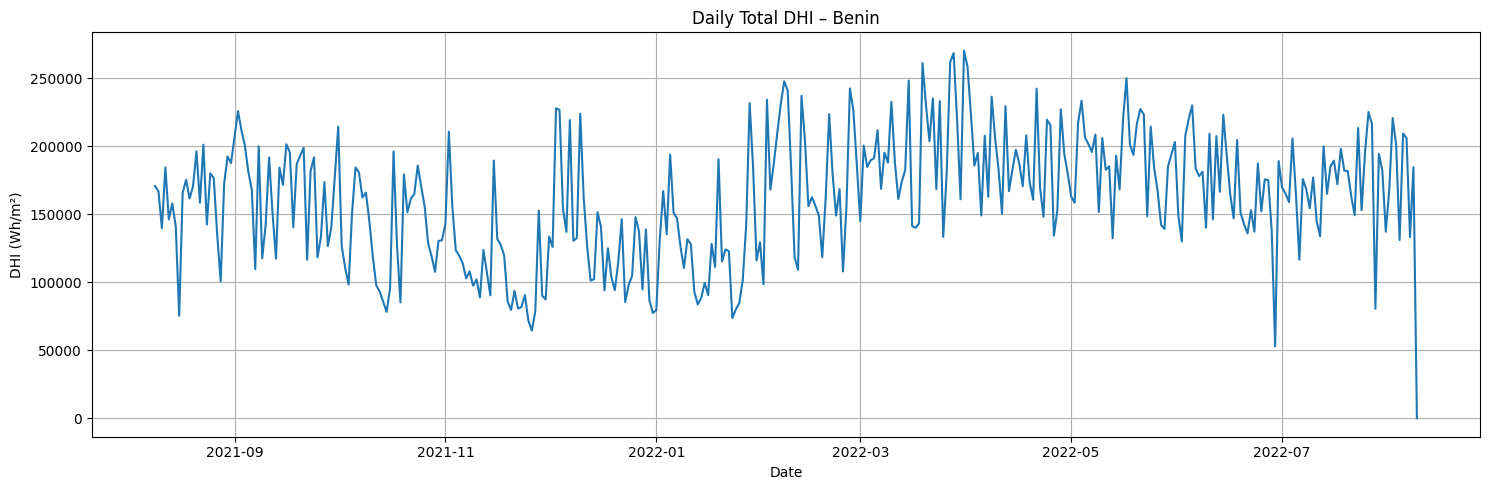

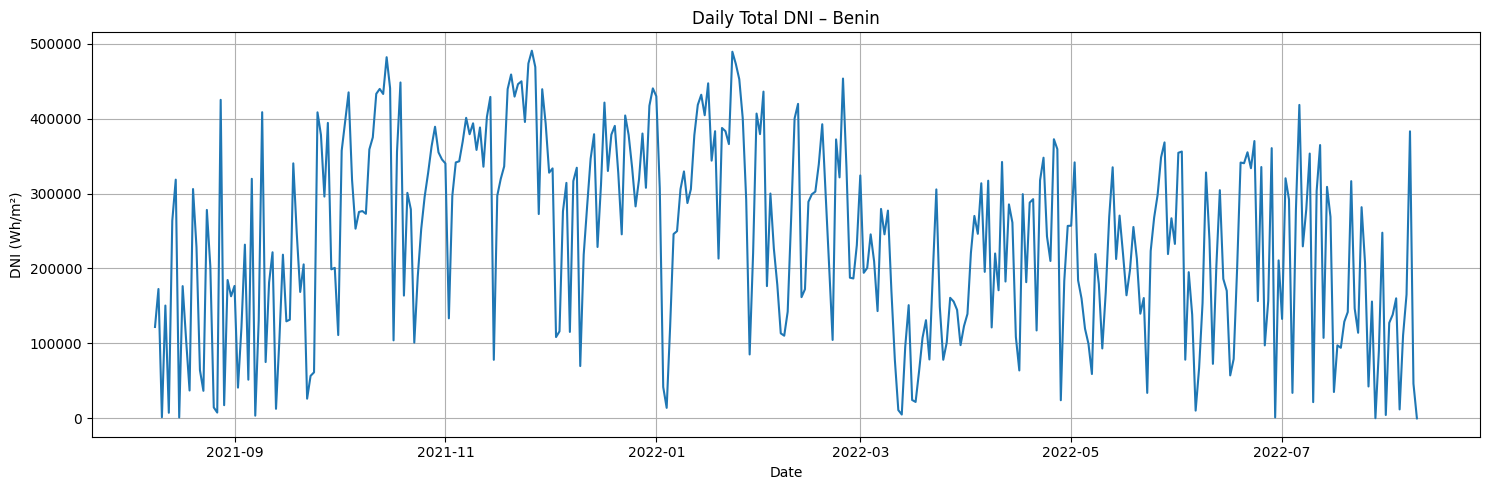

In [31]:
df['Date'] = df['Timestamp'].dt.date
daily_ghi = df.groupby('Date')['GHI'].sum()

plt.figure(figsize=(15,5))
daily_ghi.plot()
plt.title("Daily Total GHI – Benin")
plt.xlabel("Date")
plt.ylabel("GHI (Wh/m²)")
plt.grid(True)
plt.tight_layout()
plt.show()


daily_dhi = df.groupby('Date')['DHI'].sum()
plt.figure(figsize=(15,5))
daily_dhi.plot()
plt.title("Daily Total DHI – Benin")
plt.xlabel("Date")
plt.ylabel("DHI (Wh/m²)")
plt.grid(True)
plt.tight_layout()
plt.show()

Daily_dni = df.groupby('Date')['DNI'].sum()
plt.figure(figsize=(15,5))
Daily_dni.plot()
plt.title("Daily Total DNI – Benin")
plt.xlabel("Date")
plt.ylabel("DNI (Wh/m²)")
plt.grid(True)
plt.tight_layout()
plt.show()


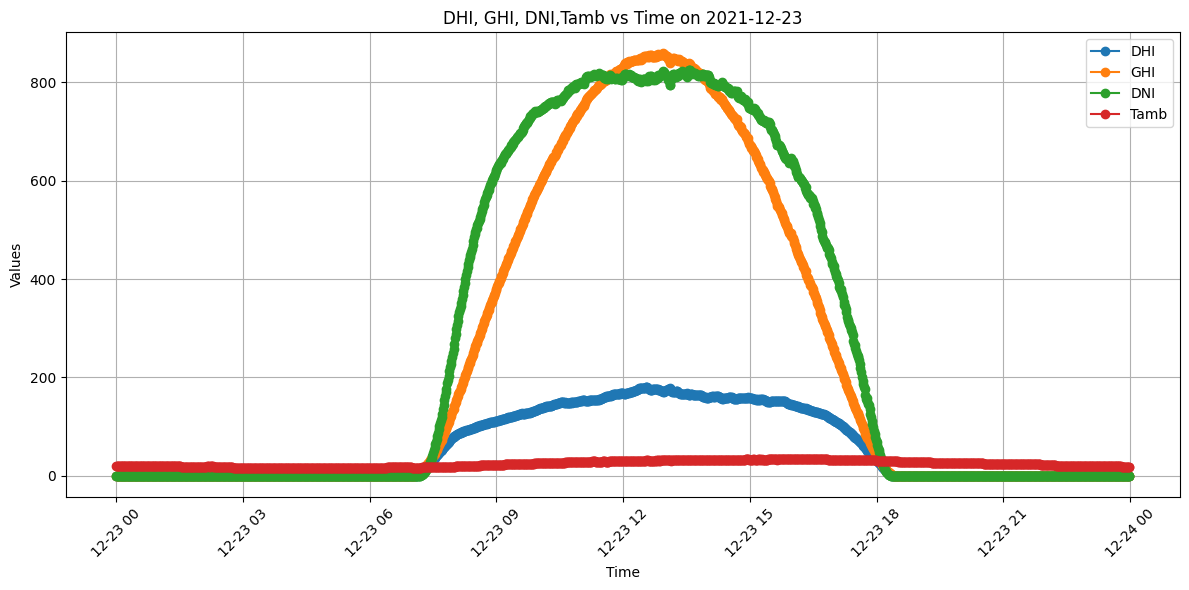

In [23]:
import random

# Select a random day from the dataset
random_day = random.choice(df['Timestamp'].dt.date.unique())

# Filter the data for the selected day
day_data = df[df['Timestamp'].dt.date == random_day]

# Plot DHI, GHI, and DNI against time
plt.figure(figsize=(12, 6))
plt.plot(day_data['Timestamp'], day_data['DHI'], label='DHI', marker='o')
plt.plot(day_data['Timestamp'], day_data['GHI'], label='GHI', marker='o')
plt.plot(day_data['Timestamp'], day_data['DNI'], label='DNI', marker='o')
plt.plot(day_data['Timestamp'], day_data['Tamb'], label='Tamb', marker='o')


plt.title(f"DHI, GHI, DNI,Tamb vs Time on {random_day}")
plt.xlabel("Time")
plt.ylabel("Values")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

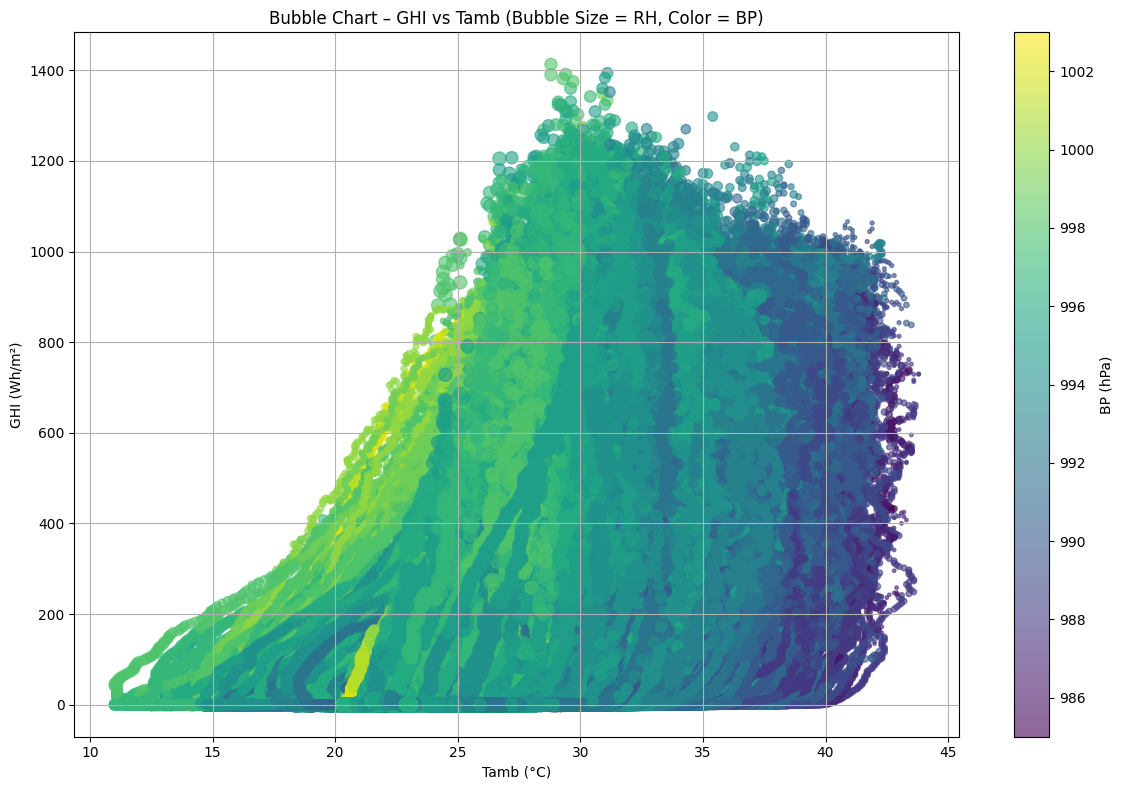

In [30]:
plt.figure(figsize=(12, 8))

# Create the bubble chart
plt.scatter(df['Tamb'], df['GHI'], s=df['RH'], alpha=0.6, c=df['BP'], cmap='viridis')

# Add labels and title
plt.title("Bubble Chart – GHI vs Tamb (Bubble Size = RH, Color = BP)")
plt.xlabel("Tamb (°C)")
plt.ylabel("GHI (Wh/m²)")
plt.colorbar(label="BP (hPa)")  # Color bar for BP
plt.grid(True)

plt.tight_layout()
plt.show()